In [2]:
# Connect to Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# do all of the imports
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import joblib
import re
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
# import string
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Load in the IMDB_sean file
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Final-Project/Resource/IMDB_eliot3.csv")
# df = pd.read_csv("Resource/IMDB_eliot2.csv")
df.head()

,Unnamed: 0,index,movie_id,movie_name,genre,plot
0,0,76,tt0006864,Intolerance,"drama, history",intolerance story poor young woman separated p...
1,1,506,tt0017136,Metropolis,"drama, sci-fi",metropolis futuristic city sharply divided wor...
2,2,566,tt0018037,Il cantante di jazz,"drama, music, musical",il cantante di jazz son jewish cantor must def...
3,3,628,tt0018773,Il circo,"comedy, romance",il circo tramp finds work girl dreams circus
4,4,714,tt0019777,The Cocoanuts,"comedy, musical",cocoanuts florida land boom


In [5]:
df = df.drop(["Unnamed: 0", "index"], axis=1)
df["genre"] = df["genre"].str.replace(' ', '')
df["genre"] = df["genre"].str.split(",")
df.head()

,movie_id,movie_name,genre,plot
0,tt0006864,Intolerance,"[drama, history]",intolerance story poor young woman separated p...
1,tt0017136,Metropolis,"[drama, sci-fi]",metropolis futuristic city sharply divided wor...
2,tt0018037,Il cantante di jazz,"[drama, music, musical]",il cantante di jazz son jewish cantor must def...
3,tt0018773,Il circo,"[comedy, romance]",il circo tramp finds work girl dreams circus
4,tt0019777,The Cocoanuts,"[comedy, musical]",cocoanuts florida land boom


In [6]:
# get all genre tags in a list
all_genres = sum(df["genre"],[])
len(set(all_genres))

21

In [7]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

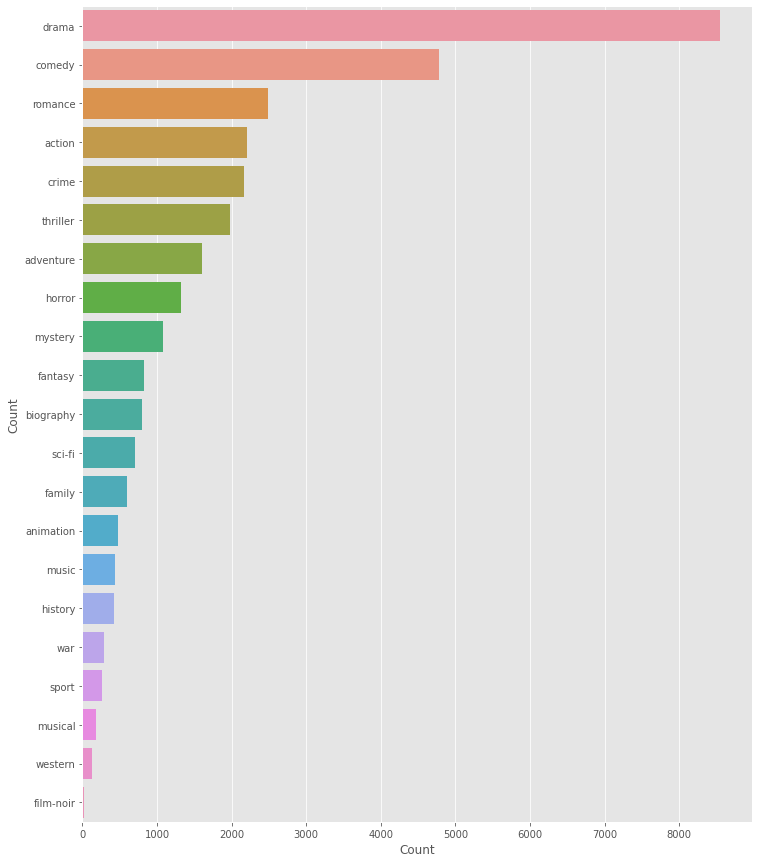

In [8]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count')
plt.savefig("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/genre_count_bar_Eliot.png", bbox_inches='tight')
plt.show()

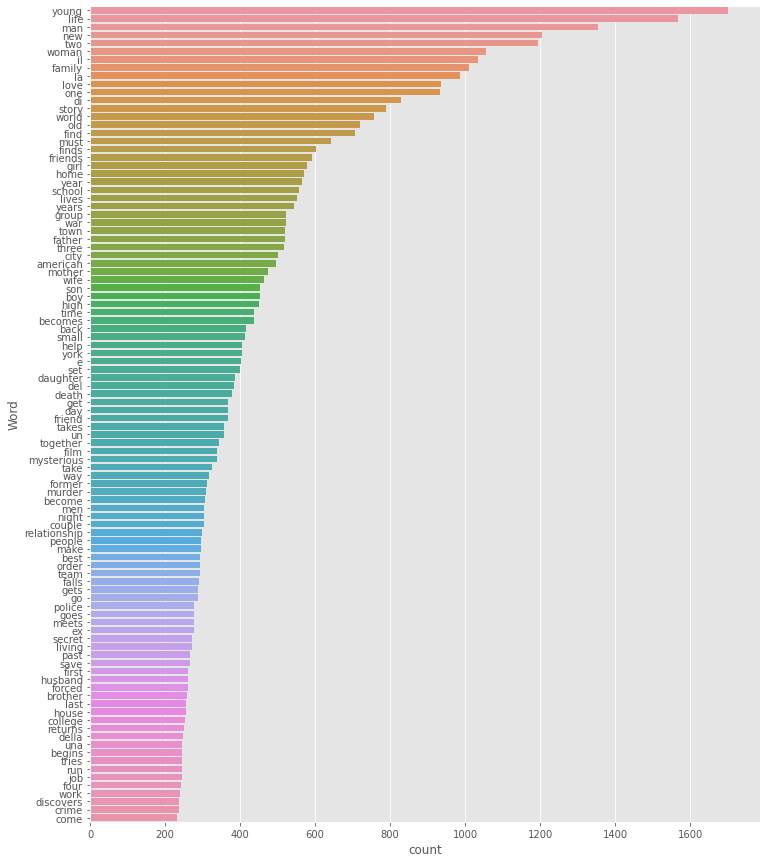

In [9]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word')
  plt.savefig("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/freq_word_bar_Eliot.png", bbox_inches='tight')
  plt.show()
  
# print 100 most frequent words 
freq_words(df['plot'], 100)

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit_transform(df['genre'])

y = multilabel_binarizer.fit_transform(df['genre'])

# transform target variable
list(multilabel_binarizer.classes_)

['action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'sport',
 'thriller',
 'war',
 'western']

In [11]:
# Define the X and y parameters
sentences = df["plot"]

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

# scale the data with StandardScaler
X_scaler = StandardScaler(with_mean=False).fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# # Label Encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# # joblib.dump(label_encoder, "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_logistic_regression_le.sav")
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)

In [12]:
from sklearn.multiclass import OneVsRestClassifier

# Run Logistic Regression
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
classifier = OneVsRestClassifier(lr)
classifier.fit(X_train_scaled, y_train)
score = classifier.score(X_test_scaled, y_test)

print("Accuracy:", score)
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Accuracy: 0.13433734939759037
Training Data Score: 1.0
Testing Data Score: 0.13433734939759037


In [13]:
classifier.get_params(deep=True)

{'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='multinomial', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 1000,
 'estimator__multi_class': 'multinomial',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'n_jobs': None}

In [14]:
# Hyperparameter Tuning
param_grid = {'estimator__C': [10, 50, 100],
              'estimator__max_iter': [200, 500, 1000]}
grid = GridSearchCV(classifier, param_grid, verbose=3)
# Train the model with GridSearch
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] estimator__C=10, estimator__max_iter=200 ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__C=10, estimator__max_iter=200, score=0.123, total=  28.4s
[CV] estimator__C=10, estimator__max_iter=200 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s remaining:    0.0s


[CV]  estimator__C=10, estimator__max_iter=200, score=0.137, total=  27.4s
[CV] estimator__C=10, estimator__max_iter=200 ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.9s remaining:    0.0s


[CV]  estimator__C=10, estimator__max_iter=200, score=0.123, total=  28.7s
[CV] estimator__C=10, estimator__max_iter=200 ........................
[CV]  estimator__C=10, estimator__max_iter=200, score=0.124, total=  28.9s
[CV] estimator__C=10, estimator__max_iter=200 ........................
[CV]  estimator__C=10, estimator__max_iter=200, score=0.130, total=  30.4s
[CV] estimator__C=10, estimator__max_iter=500 ........................
[CV]  estimator__C=10, estimator__max_iter=500, score=0.123, total=  28.3s
[CV] estimator__C=10, estimator__max_iter=500 ........................
[CV]  estimator__C=10, estimator__max_iter=500, score=0.137, total=  28.7s
[CV] estimator__C=10, estimator__max_iter=500 ........................
[CV]  estimator__C=10, estimator__max_iter=500, score=0.123, total=  29.4s
[CV] estimator__C=10, estimator__max_iter=500 ........................
[CV]  estimator__C=10, estimator__max_iter=500, score=0.124, total=  29.6s
[CV] estimator__C=10, estimator__max_iter=500 ...

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 22.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=1000,
                                                                        multi_class='multinomial',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                                                                        random

In [15]:
print(grid.best_params_)
print(grid.best_score_)

{'estimator__C': 10, 'estimator__max_iter': 200}
0.12742269933576594


In [16]:
# Save the Model
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/Eliot_Logistic_Regression.sav"
joblib.dump(classifier, file_name)

['gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/Eliot_Logistic_Regression.sav']

In [17]:
# test inverse transform to display multi-label prediction
y_pred = classifier.predict(X_test_scaled)

multilabel_binarizer.inverse_transform(y_pred)[:10]

[('comedy', 'horror'),
 ('romance',),
 ('drama',),
 ('action', 'drama'),
 ('comedy', 'drama', 'music'),
 ('comedy', 'drama', 'musical'),
 ('biography', 'drama'),
 (),
 ('drama',),
 ('thriller',)]

In [18]:
# evaluate performance, default threshold value = 0.5
f1_score(y_test, y_pred, average="micro")

0.5282934131736526

In [19]:
# predict probabilities
y_pred_prob = classifier.predict_proba(X_test_scaled)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

# evaluate performance
f1_score(y_test, y_pred_new, average="micro")

0.5437141033822591

In [20]:
# functions to display movie names and genre tags

# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower()
    
    return text

# function to remove stopwords
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

# vectorize and inverse multi-label binarizer
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = vectorizer.transform([q])
    q_pred = classifier.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [21]:
# run genre display functions
for i in range(5): 
  k = sentences_test.sample(1).index[0] 
  print("Movie: ", df['movie_name'][k], "\nPredicted genre: ", infer_tags(sentences_test[k])), print("Actual genre: ",df['genre'][k], "\n")

Movie:  She Devil Lei il diavolo 
Predicted genre:  [('drama',)]
Actual genre:  ['comedy'] 

Movie:  Freedom 
Predicted genre:  [('drama',)]
Actual genre:  ['drama', 'music'] 

Movie:  A torto o a ragione 
Predicted genre:  [('drama',)]
Actual genre:  ['drama', 'music', 'war'] 

Movie:  The Ticket 
Predicted genre:  [('drama',)]
Actual genre:  ['drama'] 

Movie:  Tango Cash 
Predicted genre:  [('drama',)]
Actual genre:  ['action', 'comedy', 'crime'] 



In [22]:
# multi-label confusion matrix
multilabel_confusion_matrix(y_test, y_pred)

cm = multilabel_confusion_matrix(y_test, y_pred)

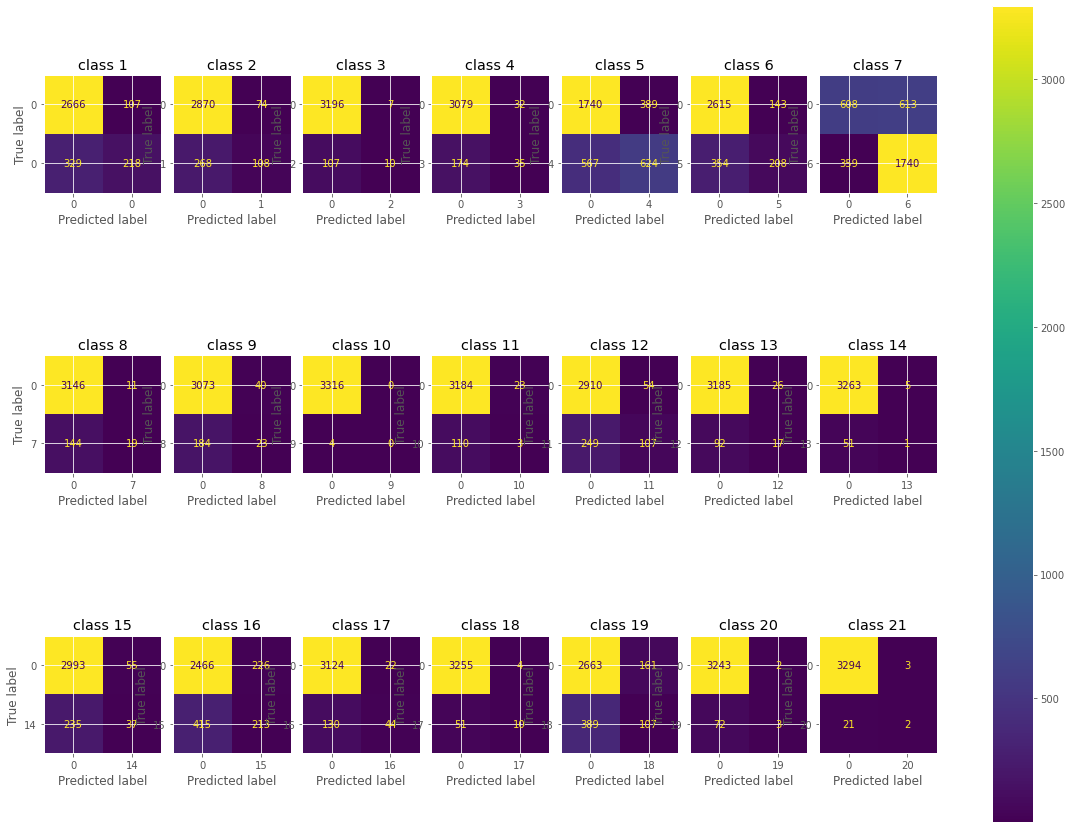

In [23]:
# plot confusion matrix for each genre label (total of 21)

f, axes = plt.subplots(3, 7, figsize=(20, 15))
axes = axes.ravel()

for i in range(21):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i + 1}')
    # if i<10:
    #     disp.ax_.set_xlabel('')
    # if i%5!=0:
    #     disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.grid(b=None)
plt.savefig("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/LR_MultiLabel_ConfusionMatrix_Eliot.png", bbox_inches='tight')
plt.show()

In [24]:
# labels = ["".join("c" + str(i)) or i in range(0, 22)]

In [25]:
# def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

#     df_cm = pd.DataFrame(
#         confusion_matrix, index=class_names, columns=class_names,
#     )

#     try:
#         heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)

#     except ValueError:
#         raise ValueError("Confusion matrix values must be integers.")
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
#     axes.set_ylabel('True label')
#     axes.set_xlabel('Predicted label')
#     axes.set_title("Confusion Matrix for the class - " + class_label)

In [26]:
# fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
# for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
#     print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

# fig.tight_layout()
# plt.show()

In [27]:

# font_size = 10
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(cm)
# ax.grid(False)
# ax.set_xlabel('Predicted outputs', fontsize=font_size, color='black')
# ax.set_ylabel('Actual outputs', fontsize=font_size, color='black')
# ax.xaxis.set(ticks=range(4))
# ax.yaxis.set(ticks=range(4))
# ax.set_ylim(3.5, -0.5)
# for i in range(4):
#     for j in range(4):
#         ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
# plt.show()
# # plt.savefig("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/LR_ConfusionMatrix.png", bbox_inches='tight')

In [28]:
# # Save the Model
# # file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_Logistic_Regression.sav"
# joblib.dump(classifier, file_name)

In [29]:
# # get a list of models to evaluate
# def get_models():
# 	models = dict()
# 	for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
# 		# create name for model
# 		key = '%.4f' % p
# 		# turn off penalty in some cases
# 		if p == 0.0:
# 			# no penalty in this case
# 			models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
# 		else:
# 			models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
# 	return models
 
# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
# 	# define the evaluation procedure
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	# evaluate the model
# 	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# 	return scores

In [30]:
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	# evaluate the model and collect the scores
# 	scores = evaluate_model(model, X_test_scaled, y_test)
# 	# store the results
# 	results.append(scores)
# 	names.append(name)
# 	# summarize progress along the way
# 	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# # plt.savefig("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/LR_PenaltyConfig.png", bbox_inches='tight')
# plt.show()